In [1]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

import re
from sklearn import linear_model
import patsy

## Data Analysis for Stocks

- DO DIFFEREN RANK FOR VALUE METRICS< SET TO BE HIGH RANK IS GOOD!!!!
    - Or do invesrion of these??

In [2]:
tmp_df = pd.read_csv('../data/VQ_data.csv')
tmp_df['d'] = pd.to_datetime(tmp_df['d'])
tmp_df = tmp_df.set_index(['d', 'insID'])

In [3]:
min_MCAP = 500
clean_df = tmp_df[tmp_df['MCAP']>min_MCAP]
horizon = 3
n_groups = 10

monthly_df =clean_df.groupby([clean_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
monthly_df['log_ret'] = monthly_df['adj_c'].groupby(level='insID').apply(lambda x: np.log(x.shift(-horizon)) - np.log(x))
monthly_df = monthly_df.unstack('insID').iloc[::horizon, :].stack('insID')

#Take rank of log ret per month values! Ranking forces it into a stationary distribution!!
monthly_df['rank_ret'] = monthly_df['log_ret'].groupby(level='d').rank(ascending=False)



#### CLEAN DATA


colmax_list = ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']

#set inf values to max
for col in colmax_list:
    m = monthly_df.loc[monthly_df[col] != np.inf, :].max()
    monthly_df.replace(np.inf,m,inplace=True)


#    #New method, more robust!!!
#for colmax in colmax_list:
#    max_tmp = monthly_df.loc[:,col].max()
#    monthly_df.loc[monthly_df[colmax]<0, colmax] = max_tmp

#Invesrt the values that should be low so they should be high
for colmax in colmax_list:
    monthly_df.loc[:, colmax] = (1/monthly_df[colmax])
    
    
### INDICATOR FUNCTION IF THE COMPANY IS IN FINANCE & RE
monthly_df['sector_ind'] = 0
monthly_df[monthly_df['sector'] == 'finance_RE']['sector_ind'] = 1
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Quintile analysis for forward 1 m return

In [4]:
col_list = monthly_df.columns.to_list()

for ele in ['c','number_Of_Shares', '1_day_ret','Name','volatility_60day',
                 'sector','market', 'acceleration', 'adj_mom', 'log_ret','adj_c', 'EA_ret', 'sector_ind']:
    try:
        col_list.remove(ele)
    except:
        print(ele)


col_list1 = col_list.copy()
col_list1.append('rank_ret')


zscore_df = pd.DataFrame()
zscore_df.index = monthly_df.index

for col in col_list1:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = monthly_df[col]
    zscore_tmp_df = zscore_tmp_df.dropna()
    #Rank for each day!! This makes it robust and stationary!! 
    # HIGH VALUE GIVES LOW RANK!!!
    zscore_tmp_df = zscore_tmp_df.groupby(level='d').rank(ascending=False)
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

    

model_list = []
for col in zscore_df.columns:
    x = re.search('zscore$', col)
    if(x!=None):
        model_list.append(col)

#group by quintiles 

for col in list(set(list(zscore_df.columns)) - set('rank_ret_zscore')):
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), n_groups, labels = range(1, n_groups + 1))
    
    
#Add indicator function for sector
zscore_df = zscore_df.join(monthly_df['sector_ind'], on=['d','insID'],how='left')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [5]:

##############################################    
#combined measures, redo z scores and groups!!
##############################################

zscore_df['comb_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore']
zscore_df['ear_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore'] + zscore_df['EAR_std_zscore']
zscore_df['val_comp'] = zscore_df['PE_zscore'] + zscore_df['PB_zscore'] +zscore_df['EVEBIT_zscore'] +zscore_df['PFCF_zscore']+zscore_df['PS_zscore']
zscore_df['qual_comp'] = zscore_df['GPA_zscore'] + zscore_df['ROIC_zscore'] +zscore_df['ROE_zscore'] + zscore_df['AT_zscore']+zscore_df['FCFROE_zscore'] + zscore_df['Asset_growth_zscore']


## REDO ZSCORE AND QUANTILES FOR COMBINED MEASURES

for col in ['comb_mom', 'ear_mom', 'val_comp', 'qual_comp']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

for col in ['comb_mom_zscore', 'ear_mom_zscore', 'val_comp_zscore', 'qual_comp_zscore']:
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), n_groups, labels = range(1, n_groups + 1))

##############################################    
######### REDO FOR COMBINATION OF COMBINATIONS, VMQ, QM, VQ, VM
#################################################

zscore_df['VMQ'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['MQ'] = zscore_df['ear_mom_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VQ'] =  zscore_df['val_comp_zscore'] +zscore_df['qual_comp_zscore']
zscore_df['VM'] = zscore_df['ear_mom_zscore'] + zscore_df['val_comp_zscore']

## REDO ZSCORE AND QUANTILES FOR COMBINED OF COMBINED MEASURES

for col in ['VMQ', 'MQ', 'VQ', 'VM']:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = zscore_df[col]
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()

for col in ['VMQ_zscore', 'MQ_zscore', 'VQ_zscore', 'VM_zscore']:
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col].rank(method='first'), n_groups, labels = range(1, n_groups + 1))




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-f

## MOMENTUM MEASURES

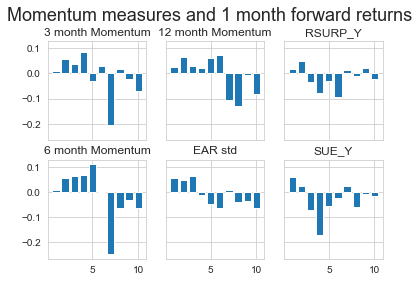

In [6]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,3, sharex=True, sharey = True)
fig.suptitle('Momentum measures and 1 month forward returns', fontsize=18, y=1)
ax[0, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("mom3_zscore_group").mean()['rank_ret_zscore']);
ax[0, 0].set_title('3 month Momentum');
ax[1, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("mom6_zscore_group").mean()['rank_ret_zscore']);
ax[1, 0].set_title('6 month Momentum');
ax[0, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("mom12_zscore_group").mean()['rank_ret_zscore']);
ax[0, 1].set_title('12 month Momentum');
ax[1, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("EAR_std_zscore_group").mean()['rank_ret_zscore']);
ax[1, 1].set_title('EAR std');
ax[0, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("RSURP_Y_zscore_group").mean()['rank_ret_zscore']);
ax[0, 2].set_title('RSURP_Y');
ax[1, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("SUE_Y_zscore_group").mean()['rank_ret_zscore']);
ax[1, 2].set_title('SUE_Y');


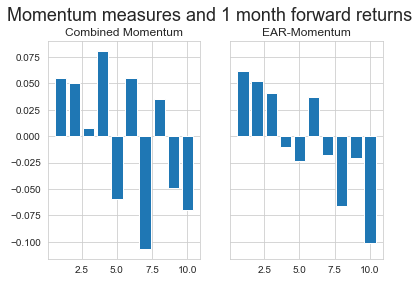

In [7]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
fig.suptitle('Momentum measures and 1 month forward returns', fontsize=18, y=1)
ax[0].bar(range(1, n_groups + 1) ,zscore_df.groupby("comb_mom_zscore_group").mean()['rank_ret_zscore']);
ax[0].set_title('Combined Momentum');
ax[1].bar(range(1, n_groups + 1) ,zscore_df.groupby("ear_mom_zscore_group").mean()['rank_ret_zscore']);
ax[1].set_title('EAR-Momentum');

### Value Measures

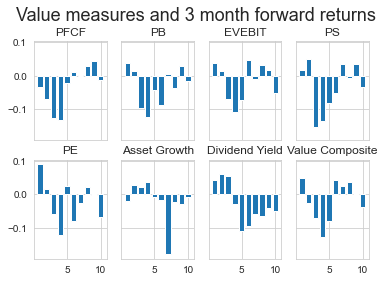

In [8]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,4, sharex=True, sharey = True)
fig.suptitle('Value measures and 3 month forward returns', fontsize=18, y=1)
ax[0, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("PFCF_zscore_group").mean()['rank_ret_zscore']);
ax[0, 0].set_title('PFCF');
ax[1, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("PE_zscore_group").mean()['rank_ret_zscore']);
ax[1, 0].set_title('PE');
ax[0, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("PB_zscore_group").mean()['rank_ret_zscore']);
ax[0, 1].set_title('PB');
ax[1, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("Asset_growth_zscore_group").mean()['rank_ret_zscore']);
ax[1, 1].set_title('Asset Growth');

ax[0, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("EVEBIT_zscore_group").mean()['rank_ret_zscore']);
ax[0, 2].set_title('EVEBIT');
ax[1, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("DIV_Y_zscore_group").mean()['rank_ret_zscore']);
ax[1, 2].set_title('Dividend Yield');

ax[0, 3].bar(range(1, n_groups + 1) ,zscore_df.groupby("PS_zscore_group").mean()['rank_ret_zscore']);
ax[0, 3].set_title('PS');
ax[1, 3].bar(range(1, n_groups + 1) ,zscore_df.groupby("val_comp_zscore_group").mean()['rank_ret_zscore']);
ax[1, 3].set_title('Value Composite');

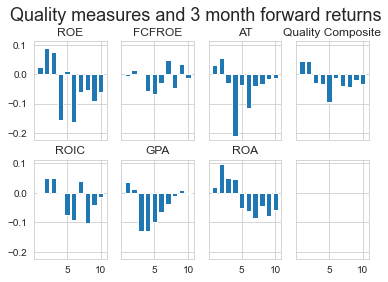

In [9]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,4, sharex=True, sharey = True)
fig.suptitle('Quality measures and 3 month forward returns', fontsize=18, y=1)
ax[0, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("ROE_zscore_group").mean()['rank_ret_zscore']);
ax[0, 0].set_title('ROE');
ax[1, 0].bar(range(1, n_groups + 1) ,zscore_df.groupby("ROIC_zscore_group").mean()['rank_ret_zscore']);
ax[1, 0].set_title('ROIC');
ax[0, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("FCFROE_zscore_group").mean()['rank_ret_zscore']);
ax[0, 1].set_title('FCFROE');
ax[1, 1].bar(range(1, n_groups + 1) ,zscore_df.groupby("GPA_zscore_group").mean()['rank_ret_zscore']);
ax[1, 1].set_title('GPA');

ax[0, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("AT_zscore_group").mean()['rank_ret_zscore']);
ax[0, 2].set_title('AT');
ax[1, 2].bar(range(1, n_groups + 1) ,zscore_df.groupby("ROA_zscore_group").mean()['rank_ret_zscore']);
ax[1, 2].set_title('ROA');

ax[0, 3].bar(range(1, n_groups + 1) ,zscore_df.groupby("qual_comp_zscore_group").mean()['rank_ret_zscore']);
ax[0, 3].set_title('Quality Composite');


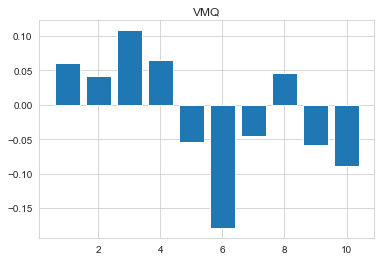

In [10]:
sns.set_style("whitegrid")
plt.bar(range(1, n_groups + 1), zscore_df.groupby("VMQ_zscore_group").mean()['rank_ret_zscore']);
plt.title('VMQ');

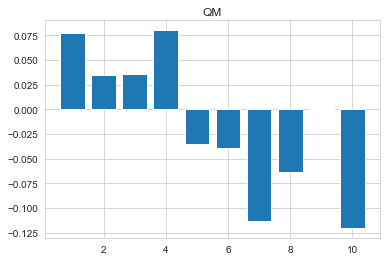

In [11]:
sns.set_style("whitegrid")
plt.bar(range(1, n_groups + 1), zscore_df.groupby("MQ_zscore_group").mean()['rank_ret_zscore']);
plt.title('QM');

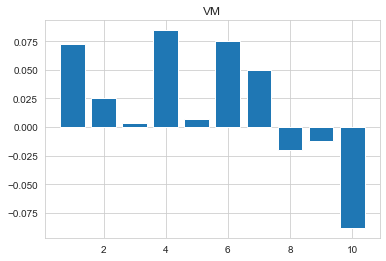

In [12]:
sns.set_style("whitegrid")
plt.bar(range(1, n_groups + 1), zscore_df.groupby("VM_zscore_group").mean()['rank_ret_zscore']);
plt.title('VM');

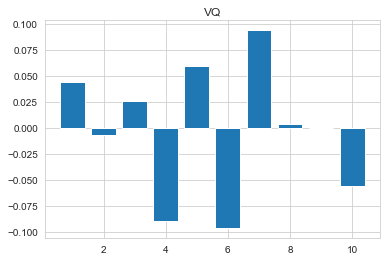

In [13]:
sns.set_style("whitegrid")
plt.bar(range(1, n_groups + 1), zscore_df.groupby("VQ_zscore_group").mean()['rank_ret_zscore']);
plt.title('VQ');

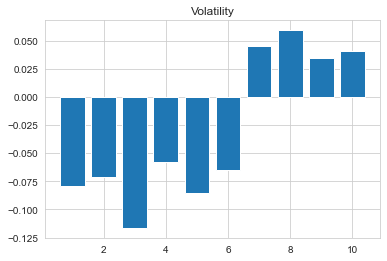

In [14]:
sns.set_style("whitegrid")
plt.bar(range(1, n_groups + 1), zscore_df.groupby("volatility_zscore_group").mean()['rank_ret_zscore']);
plt.title('Volatility');

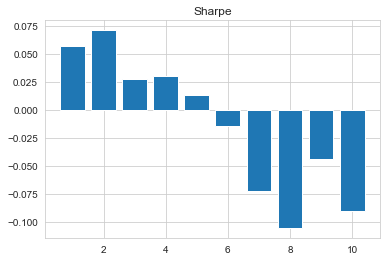

In [15]:
sns.set_style("whitegrid")
plt.bar(range(1, n_groups + 1), zscore_df.groupby("sharpe_zscore_group").mean()['rank_ret_zscore']);
plt.title('Sharpe');

## SIMPEL LINEAR MODEL

In [16]:
coeff_list = model_list.copy()
coeff_list.remove('rank_ret_zscore')


In [17]:
coeff_list

['MCAP_zscore',
 'PE_zscore',
 'GPA_zscore',
 'GPA_chg_zscore',
 'Asset_growth_zscore',
 'PB_zscore',
 'EAR_std_zscore',
 'EVEBIT_zscore',
 'EVFCF_zscore',
 'ROIC_zscore',
 'ROE_zscore',
 'ROE_chg_zscore',
 'AT_zscore',
 'RSURP_Y_zscore',
 'rev_growth_zscore',
 'SUE_Y_zscore',
 'EPS_growth_zscore',
 'EPS_acceleration_zscore',
 'mom12_zscore',
 'mom6_zscore',
 'mom3_zscore',
 'mom1_zscore',
 'volatility_zscore',
 'sharpe_zscore',
 'high_12m_zscore',
 'high_6m_zscore',
 'high_3m_zscore',
 'high_1m_zscore',
 'high_2y_zscore',
 'low_1m_zscore',
 'low_3m_zscore',
 'low_6m_zscore',
 'low_12m_zscore',
 'low_2y_zscore',
 'skew_zscore',
 'EMA_32_96_zscore',
 'EMA_96_288_zscore',
 'range_2y_zscore',
 'range_12m_zscore',
 'range_6m_zscore',
 'range_3m_zscore',
 'range_1m_zscore',
 'FCFROE_zscore',
 'ROA_zscore',
 'PS_zscore',
 'PFCF_zscore',
 'DIV_Y_zscore',
 'res_mom12_zscore',
 'MEME_factor_zscore',
 'MA20_VOL_zscore',
 'volume_balance_zscore',
 'MA20_zscore',
 'MA50_VOL_zscore',
 'Gross_margin

In [18]:
coeff_list_comp = coeff_list

## 1 month returns

In [27]:
#coeff_list_comp = ['qual_comp_zscore', 'val_comp_zscore', 'ear_mom_zscore']
#coeff_list_comp = [ 'mom12_zscore', 'mom6_zscore',  'EAR_std_zscore']
#coeff_list_comp = ['EVEBIT_zscore','Asset_growth_zscore', 'PS_zscore', 'PB_zscore', 'PE_zscore', 'mom12_zscore',  'mom6_zscore', 'EAR_std_zscore', ]

#coeff_list_comp = [ 'EAR_std_zscore','mom12_zscore', 'mom6_zscore','res_mom12_zscore', 'volatility_zscore']
coeff_list_comp = ['mom12_zscore','alpha_zscore', 'beta_zscore', 'res_mom12_zscore']

#coeff_list_comp = ['qual_comp_zscore', 'val_comp_zscore', 'ear_mom_zscore', 'EMA_32_96_zscore', 'EMA_96_288_zscore']
#coeff_list_comp = mom_coeff + ['volatility_zscore', 'EAR_std_zscore']

y = pd.DataFrame(zscore_df['rank_ret_zscore'])
X = zscore_df[coeff_list_comp]

model_list = coeff_list_comp.copy()
model_list.append('rank_ret_zscore')

formula = y.columns[0] + ' ~ ' 


#coeff_list_comp_tmp = ['qual_comp_zscore', 'val_comp_zscore','volatility_zscore', 'ear_mom_zscore']
coeff_list_comp_tmp = coeff_list_comp

#for coeff in X.columns.tolist():
for coeff in coeff_list_comp_tmp:
        formula = formula + coeff + " + " 
        
for coeff_i in coeff_list_comp_tmp:
    for coeff_j in coeff_list_comp_tmp:
        if coeff_i != coeff_j:
            formula = formula + coeff_i+":"+ coeff_j + " + "



formula = formula[:-3]
reg_df = zscore_df.dropna()
### MAKE NEGATIVE values positive for ranking

turn_positive = ['mom12_zscore', 'mom6_zscore', 'mom3_zscore', 'high_12m_zscore',
        'high_6m_zscore', 'high_3m_zscore', 'EAR_std_zscore','qual_comp_zscore', 
                 'val_comp_zscore','ear_mom_zscore', 'EMA_32_96_zscore', 'EMA_96_288_zscore', 'sharpe_zscore' ]

reg_df.loc[:,turn_positive ] = -reg_df.loc[:,turn_positive ]


est2 = smf.ols(formula= formula, data=reg_df[model_list]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
print(est2.summary())


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


                            OLS Regression Results                            
Dep. Variable:        rank_ret_zscore   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.65
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           0.000377
Time:                        08:58:41   Log-Likelihood:                -20591.
No. Observations:               14539   AIC:                         4.119e+04
Df Residuals:                   14537   BIC:                         4.120e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.728e-05      0.008  

## Correlation Analysis

In [23]:
zscore_df[coeff_list_comp].corr(method = 'spearman')

,mom12_zscore,alpha_zscore,beta_zscore,res_mom12_zscore
mom12_zscore,1.000000,0.466427,0.029562,0.585922
alpha_zscore,0.466427,1.000000,-0.139732,0.059985
beta_zscore,0.029562,-0.139732,1.000000,-0.012311
res_mom12_zscore,0.585922,0.059985,-0.012311,1.000000


In [24]:
import pandas as pd
import scipy.cluster.hierarchy as spc

corr = zscore_df[coeff_list_comp].corr(method = 'spearman').values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
#idx = spc.fcluster(linkage, 3, 'maxclust')

In [25]:
idx

array([1, 2, 3, 1], dtype=int32)

In [26]:
coeff_list_comp

['mom12_zscore', 'alpha_zscore', 'beta_zscore', 'res_mom12_zscore']